<a href="https://colab.research.google.com/github/kotech1/computervision/blob/master/13_funtopics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

실습파일: `13-funtopics.ipynb`

# Adversarial attack

In [1]:
%tensorflow_version 2.x

**Fast Gradient Signed Method**

In [2]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False


**MobileNetV2를 네트워크로 이용**  
ImageNet에서 사전 훈련된 weights 사용

In [3]:
import keras
pretrained_model = keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet 클래스 레이블
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

14540800/14536120 [==============================] - 0s 0us/step


In [7]:
# 이미지가 MobileNetV2에 전달될 수 있도록 전처리해주는 헬퍼 메서드(helper function)
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = image/255
  image = tf.image.resize(image, (224, 224))
  image = image[None, ...]
  return image

# 확률 벡터에서 레이블을 추출해주는 헬퍼 메서드
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

**정상적으로 인식되는 이미지 샘플 다운로드**

In [11]:
image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

In [10]:
image_probs.shape

(1, 1000)

40960/35363 [==================================] - 0s 0us/step


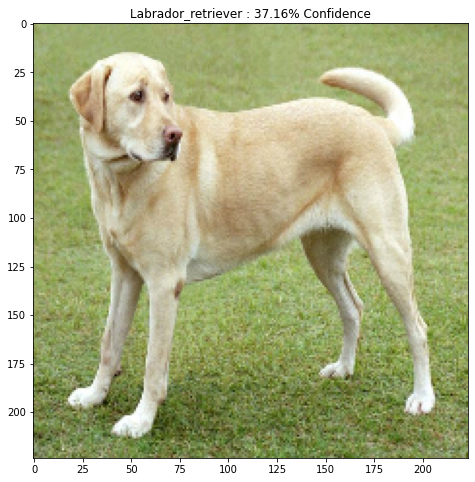

In [12]:
plt.figure()
plt.imshow(image[0])
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()


**FGSM으로 공격 패턴 만들기**
1. GradientTape으로 미분 추적기능 활성화  
2. input_image에 대한 미분만 추적 (`tape.watch(input_image)`)  
3. 모델에 입력영상을 넣고, prediction 수행  
4. Ground truth(`input_label`)와, 예측치(`prediction`)간의 교차 엔트로피를 `loss`로 계산  
5. `loss`를 `input_image`에 대해 미분(gradient)한 것에 대한 결과:  
   `gradient` 
6. Gradient에 대한 부호값만 `signed_grad`에 저장하고 반환  

In [13]:
loss_object = keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # 입력 이미지에 대한 손실 함수의 기울기를 구합니다.
  gradient = tape.gradient(loss, input_image)
  # 왜곡을 생성하기 위해 그래디언트의 부호를 구합니다.
  signed_grad = tf.sign(gradient)
  return signed_grad

1. 래브라도 리트리버 class에 대한 ground truth data('label') 생성  
2. 위에서 정의한 공격 패턴 생성 함수 호출    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


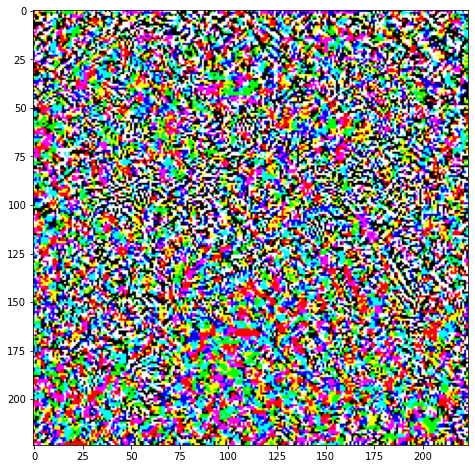

In [14]:
# 이미지의 레이블 위치만 1로 설정 (기본적인 클래스 분류기 결과)
labrador_retriever_index = 208
label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

# 공격 패턴 생성
perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0])
plt.show()

**공격 패턴을 적용하고 이미지 및 결과를 출력해주는 함수 정의**

In [16]:
# 인식하고 이미지 출력
def display_images(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0])
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()


**Scale factor인 $\epsilon$을 서서히 증가시키면서 공격 결과 관측**

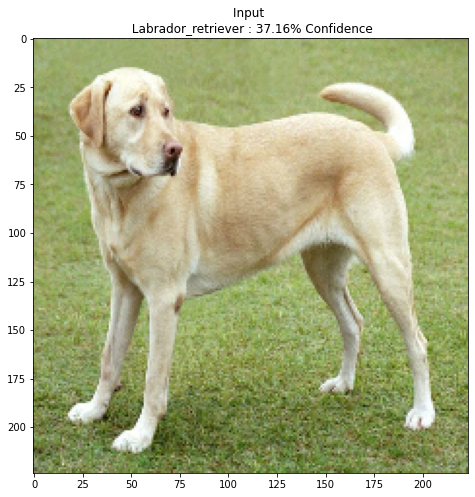

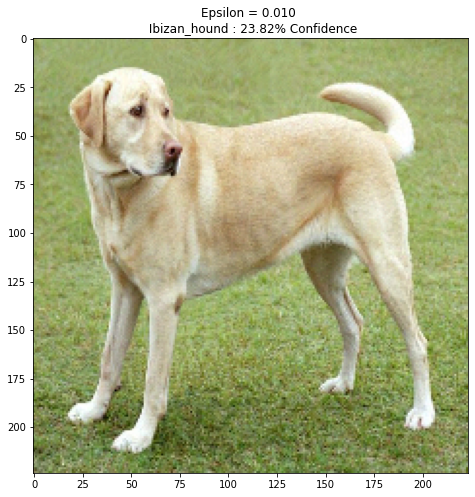

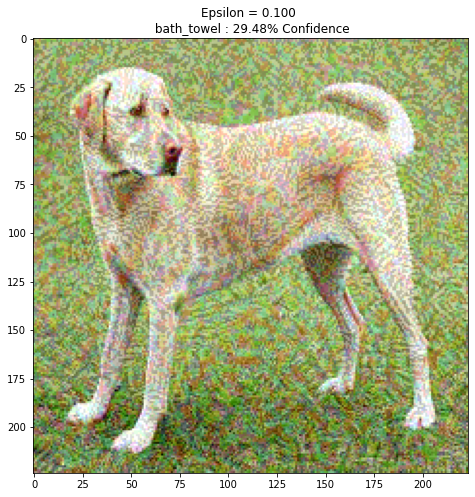

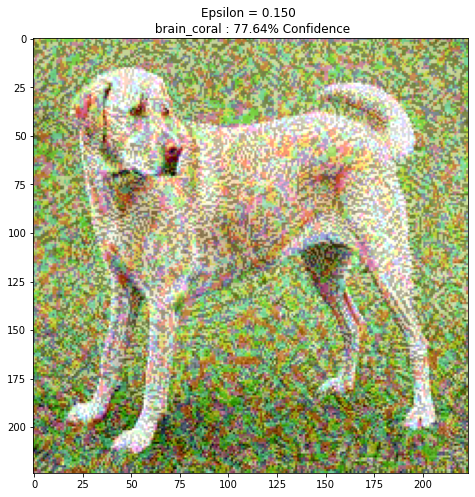

In [18]:
# epsilon을 변경하면서 결과 관찰
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, 0, 1)
  display_images(adv_x, descriptions[i])

# StyleGAN

StyleGAN 소스 코드: 

**주의 사항**  
StyleGAN은 tensorflow 1.x 버전 소스입니다.  
런타임 -> 런타임 다시 시작을 선택하신 후 StyleGAN 부분부터 실행합니다. 

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


StyleGAN repo 복사

In [3]:
!git clone https://github.com/NVlabs/stylegan2.git

Cloning into 'stylegan2'...
remote: Enumerating objects: 122, done.
remote: Total 122 (delta 0), reused 0 (delta 0), pack-reused 122
Receiving objects: 100% (122/122), 590.23 KiB | 14.05 MiB/s, done.
Resolving deltas: 100% (55/55), done.


**명령어로 StyleGan 실행**

In [ ]:
!python /content/stylegan2/run_generator.py generate-images \
    --network=gdrive:networks/stylegan2-ffhq-config-f.pkl \
  --seeds=6600-6625 --truncation-psi=0.5

Local submit - run_dir: results/00000-generate-images
dnnlib: Running run_generator.generate_images() on localhost...
Loading networks from "gdrive:networks/stylegan2-ffhq-config-f.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.
Generating image for seed 6600 (0/26) ...
Generating image for seed 6601 (1/26) ...
Generating image for seed 6602 (2/26) ...
Generating image for seed 6603 (3/26) ...
Generating image for seed 6604 (4/26) ...
Generating image for seed 6605 (5/26) ...
Generating image for seed 6606 (6/26) ...
Generating image for seed 6607 (7/26) ...
Generating image for seed 6608 (8/26) ...
Generating image for seed 6609 (9/26) ...
Generating image for seed 6610 (10/26) ...
Generating image for seed 6611 (11/26) ...
Generating image for seed 6612 (12/26) ...
Generating image for seed 6613 (13/26) ...
Generating image for seed 661

In [ ]:
!ls /content/results/00000-generate-images

In [ ]:
!mkdir -p /content/drive/My\ Drive/projects/stylegan2

In [ ]:
cp /content/results/00000-generate-images/* \
    /content/drive/My\ Drive/projects/stylegan2

# 파이썬으로 StyleGAN2 실행하기

StyleGAN 폴더를 파이썬에 추가해서, 폴더를 이동하지 않고도 import하도록 함.  

In [4]:
import sys
sys.path.insert(0, "/content/stylegan2")

import dnnlib

**본 소스 코드의 저작권은 NVIDIA에게 있습니다.**  
사용에 대한 제한 조건에 대해서는 아래의 링크를 참조하세요.  
https://nvlabs.github.io/stylegan2/license.html  


In [5]:
# Copyright (c) 2019, NVIDIA Corporation. All rights reserved.
#
# This work is made available under the Nvidia Source Code License-NC.
# To view a copy of this license, visit
# https://nvlabs.github.io/stylegan2/license.html

import argparse
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import re
import sys

import pretrained_networks

#----------------------------------------------------------------------------
# 시드로부터 랜덤 넘버 생성  
# vector_size: 512 차원
def expand_seed(seeds, vector_size):
  result = []

  for seed in seeds:
    rnd = np.random.RandomState(seed)
    result.append( rnd.randn(1, vector_size) ) 
  return result

def generate_images(Gs, seeds, truncation_psi):
    noise_vars = [var for name, var in \
                  Gs.components.synthesis.vars.items() \
                  if name.startswith('noise')]

    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func= \
        tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    if truncation_psi is not None:
        Gs_kwargs.truncation_psi = truncation_psi

    for seed_idx, seed in enumerate(seeds):
        print('Generating image for seed %d/%d ...' % (seed_idx, len(seeds)))
        rnd = np.random.RandomState()
        tflib.set_vars({var: rnd.randn(*var.shape.as_list()) \
                        for var in noise_vars}) # [height, width]
        images = Gs.run(seed, None, **Gs_kwargs) 
        # [minibatch, height, width, channel]
        path = f"/content/drive/My Drive/projects/"+\
                f"stylegan2/image{seed_idx}.png"
        PIL.Image.fromarray(images[0], 'RGB').save(path)

def main():
    sc = dnnlib.SubmitConfig()
    sc.num_gpus = 1
    sc.submit_target = dnnlib.SubmitTarget.LOCAL
    sc.local.do_not_copy_source_files = True
    sc.run_dir_root = "/content/drive/My Drive/projects/stylegan2"
    sc.run_desc = 'generate-images'
    network_pkl = 'gdrive:networks/stylegan2-ffhq-config-f.pkl'

    print('Loading networks from "%s"...' % network_pkl)
    _G, _D, Gs = pretrained_networks.load_networks(network_pkl)
    vector_size = Gs.input_shape[1:][0]
    seeds = expand_seed( range(8040,8090), vector_size)
    generate_images(Gs, seeds,truncation_psi=0.5)

#----------------------------------------------------------------------------

if __name__ == "__main__":
    main()

#----------------------------------------------------------------------------

Loading networks from "gdrive:networks/stylegan2-ffhq-config-f.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.
Generating image for seed 0/50 ...
Generating image for seed 1/50 ...
Generating image for seed 2/50 ...
Generating image for seed 3/50 ...
Generating image for seed 4/50 ...
Generating image for seed 5/50 ...
Generating image for seed 6/50 ...
Generating image for seed 7/50 ...
Generating image for seed 8/50 ...
Generating image for seed 9/50 ...
Generating image for seed 10/50 ...
Generating image for seed 11/50 ...
Generating image for seed 12/50 ...
Generating image for seed 13/50 ...
Generating image for seed 14/50 ...
Generating image for seed 15/50 ...
Generating image for seed 16/50 ...
Generating image for seed 17/50 ...
Generating image for seed 18/50 ...
Generating image for seed 19/50 ...
Generating image for seed 20/

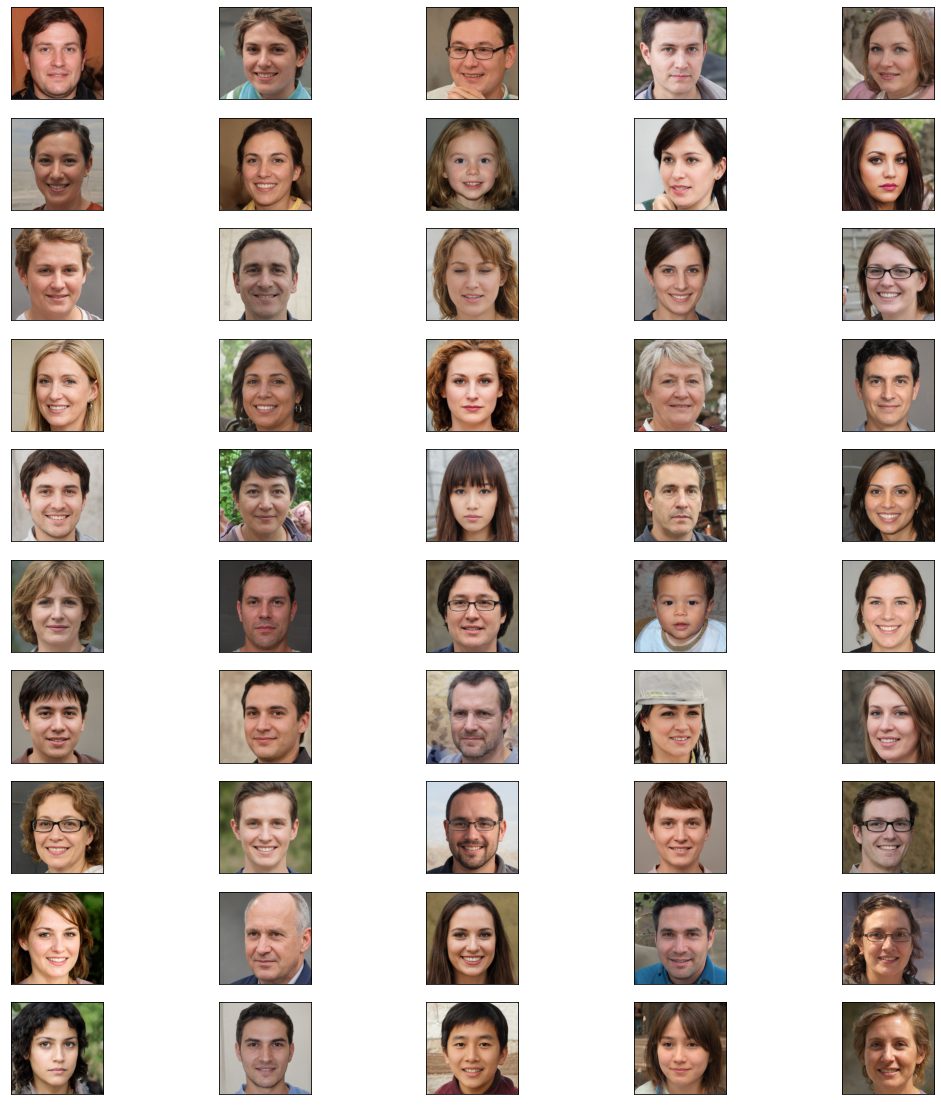

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mp_image

cols = 5
rows = 10

plt.figure(figsize=(18,20))
for j in range(rows):
  for i in range(cols):
    plt.subplot(rows, cols, i+j*cols+1)
    img = mp_image.imread('/content/drive/My Drive/projects/stylegan2/image%d.png' % (i+j*cols))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.show()

In [7]:
sc = dnnlib.SubmitConfig()
sc.num_gpus = 1
sc.submit_target = dnnlib.SubmitTarget.LOCAL
sc.local.do_not_copy_source_files = True
sc.run_dir_root = "/content/drive/My Drive/projects/stylegan2"
sc.run_desc = 'generate-images'
network_pkl = 'gdrive:networks/stylegan2-ffhq-config-f.pkl'

print('Loading networks from "%s"...' % network_pkl)
_G, _D, Gs = pretrained_networks.load_networks(network_pkl)
vector_size = Gs.input_shape[1:][0]
# range(8192,8300)
start = 8448
#seeds = expand_seed( [8192+1,8192+9], vector_size)
seeds = expand_seed( [8087,8088], vector_size)

#generate_images(Gs, seeds,truncation_psi=0.5)
print(seeds[0].shape)

Loading networks from "gdrive:networks/stylegan2-ffhq-config-f.pkl"...
(1, 512)


In [8]:
# 8192+1,8192+9

STEPS = 300
diff = seeds[1] - seeds[0]
step = diff / STEPS
current = seeds[0].copy()

seeds2 = []
for i in range(STEPS):
  seeds2.append(current)
  current = current + step

generate_images(Gs, seeds2,truncation_psi=0.5)

Generating image for seed 0/300 ...
Generating image for seed 1/300 ...
Generating image for seed 2/300 ...
Generating image for seed 3/300 ...
Generating image for seed 4/300 ...
Generating image for seed 5/300 ...
Generating image for seed 6/300 ...
Generating image for seed 7/300 ...
Generating image for seed 8/300 ...
Generating image for seed 9/300 ...
Generating image for seed 10/300 ...
Generating image for seed 11/300 ...
Generating image for seed 12/300 ...
Generating image for seed 13/300 ...
Generating image for seed 14/300 ...
Generating image for seed 15/300 ...
Generating image for seed 16/300 ...
Generating image for seed 17/300 ...
Generating image for seed 18/300 ...
Generating image for seed 19/300 ...
Generating image for seed 20/300 ...
Generating image for seed 21/300 ...
Generating image for seed 22/300 ...
Generating image for seed 23/300 ...
Generating image for seed 24/300 ...
Generating image for seed 25/300 ...
Generating image for seed 26/300 ...
Generating 

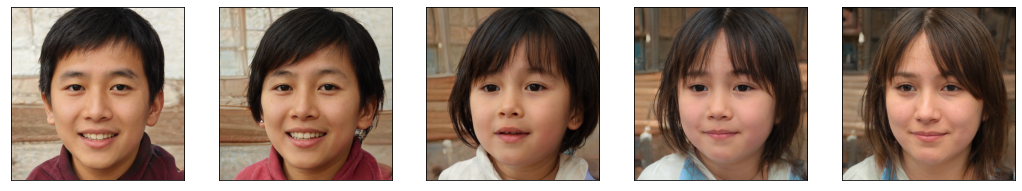

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mp_image

steps=STEPS
cols = 5
ids = []
for i in range(cols):
    id = np.floor(i*(steps-1)/(cols-1)).astype('int')
    ids.append(id)

plt.figure(figsize=(18,8))
for i in range(cols):
  plt.subplot(1, cols, i+1)
  img = mp_image.imread('/content/drive/My Drive/projects/stylegan2/image%d.png' % ids[i])
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
plt.show()

In [10]:
!ls '/content/drive/My Drive/projects/stylegan2'

100-100.png    image138.png  image203.png  image26.png	 image65.png
100-1789.png   image139.png  image204.png  image270.png  image66.png
100-293.png    image13.png   image205.png  image271.png  image67.png
100-55.png     image140.png  image206.png  image272.png  image68.png
100-821.png    image141.png  image207.png  image273.png  image69.png
1500-1500.png  image142.png  image208.png  image274.png  image6.png
1500-1789.png  image143.png  image209.png  image275.png  image70.png
1500-293.png   image144.png  image20.png   image276.png  image71.png
1500-55.png    image145.png  image210.png  image277.png  image72.png
1500-821.png   image146.png  image211.png  image278.png  image73.png
1789-1789.png  image147.png  image212.png  image279.png  image74.png
293-293.png    image148.png  image213.png  image27.png	 image75.png
458-1789.png   image149.png  image214.png  image280.png  image76.png
458-293.png    image14.png   image215.png  image281.png  image77.png
458-458.png    image150.png  image216

In [ ]:
#!rm /content/drive/My\ Drive/projects/stylegan2/*.png

**스타일 믹싱**

col-seeds: 열 램덤 시드  
row-seeds: 행 랜덤 시드  
col의 스타일 ('0-6')을 row에 이식  


In [11]:
!python /content/stylegan2/run_generator.py style-mixing-example \
    --network=gdrive:networks/stylegan2-ffhq-config-f.pkl \
    --row-seeds=85,100,75,458,1500 --col-seeds=55,821,1789,293 \
    --truncation-psi=1.0

    #--col-styles='0-6'

Local submit - run_dir: results/00000-style-mixing-example
dnnlib: Running run_generator.style_mixing_example() on localhost...
Loading networks from "gdrive:networks/stylegan2-ffhq-config-f.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.
Generating W vectors...
Generating images...
2020-11-12 14:49:43.886935: W tensorflow/core/common_runtime/bfc_allocator.cc:305] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
Generating style-mixed images...
Saving images

In [19]:
!ls results

00000-style-mixing-example


In [20]:
!ls /content/results/00000-style-mixing-example

100-100.png    1500-293.png   458-458.png  75-75.png	85-85.png
100-1789.png   1500-55.png    458-55.png   75-821.png	_finished.txt
100-293.png    1500-821.png   458-821.png  821-821.png	grid.png
100-55.png     1789-1789.png  55-55.png    85-1789.png	log.txt
100-821.png    293-293.png    75-1789.png  85-293.png	run.txt
1500-1500.png  458-1789.png   75-293.png   85-55.png	submit_config.pkl
1500-1789.png  458-293.png    75-55.png    85-821.png	submit_config.txt


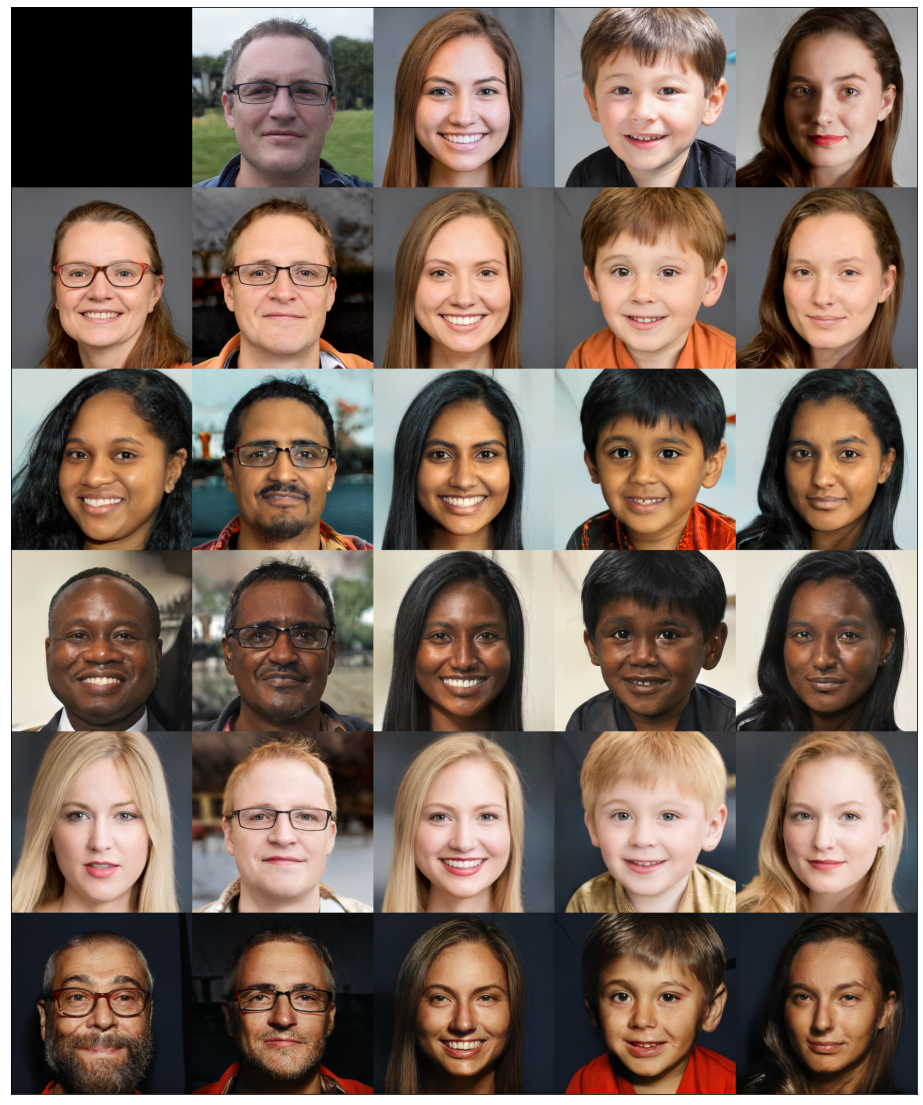

In [21]:
import matplotlib.pyplot as plt
import matplotlib.image as mp_image
image = mp_image.imread('/content/results/00000-style-mixing-example/grid.png')
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.show()

# 동영상 만들기

참조 노트북 파일:  
https://colab.research.google.com/github/yunooooo/FFmpeg-for-Google-Drive/blob/master/FFmpeg.ipynb

**ffmepg 설치**

In [22]:
#@title <font size="5">← ឵឵<i>FFMPEG 설치</font> { vertical-output: true }
from IPython.display import clear_output
import os, urllib.request
HOME = os.path.expanduser("~")
pathDoneCMD = f'{HOME}/doneCMD.sh'
if not os.path.exists(f"{HOME}/.ipython/ttmg.py"):
    hCode = "https://raw.githubusercontent.com/yunooooo/gcct/master/res/ttmg.py"
    urllib.request.urlretrieve(hCode, f"{HOME}/.ipython/ttmg.py")

from ttmg import (
    loadingAn,
    textAn,
)

loadingAn(name="lds")
textAn("Installing Dependencies...", ty='twg')
os.system('pip install git+git://github.com/AWConant/jikanpy.git')
os.system('add-apt-repository -y ppa:jonathonf/ffmpeg-4')
os.system('apt-get update')
os.system('apt install mediainfo')
os.system('apt-get install ffmpeg')
clear_output()
print('Installation finished.')

Installation finished.


In [23]:
!ffmpeg -r 30 -i '/content/drive/My Drive/projects/stylegan2/image%d.png' -y video.mp4

ffmpeg version 4.3.1-0york0~18.04 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version='0york0~18.04' --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab